In [2]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.3', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.0', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import MSELoss
from torch.optim import LBFGS, SGD,Adam 

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch.optim as optim

from pandas.core.common import flatten

# Load in some additional functions from a text file
from helpers import parity

In [4]:
# Set up the QuantumInstance we'll use to run things
qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [5]:
import torch
torch.cuda.is_available()

False

# Pull in a data set

In [6]:
# Replace this
dataSetID = '0'

# Define the directory paths
data0Path = r'../../dataset/data{0}.txt'.format(dataSetID)
data0Label = r'../../dataset/data{0}label.txt'.format(dataSetID)

# Load in the data
dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data = list(zip(dataCoords, 2*dataLabels-1))

In [7]:
def generate_train_validate_test_data(data, train_size=100, validate_size=500, randomSeed=0):
    r'''This is a function which, given a dataset, will return 3 distinct datasets from it: a training dataset,
    a validation dataset, and a testing dataset.
    
    The size of the training and validation datasets is set by the function call; the size of the testing
    dataset is the remainder of the data after training & validation dataset have been generated.'''
    
    assert len(data) > train_size+validate_size, 'Not enough data to do the splitting.'
    
    def generate_data(data, ixs):
        r'''Helper function for generating data.'''
        X= [np.array(list(flatten([data[j][0],data[j][0]]))) for j in ixs]
        y = [data[j][1] for j in ixs]    
    
        # Recast X as a pyTorch tensor
        X = Tensor(X)
        
        # Change how the data is labeled: {-1,+1} --> {0, 1}
        y =  [ (x + 1)/2 for x in y]
        
        return X, y
    
    # At the start, we could use all possible datapoints for training
    possible_ixs = range(len(data))
    
    # Training data
    np.random.seed(randomSeed)
    train_ixs = np.random.choice(possible_ixs, size=train_size)
    train_X, train_y = generate_data(data, train_ixs)
    
    # Update the possible indices we could choose from
    possible_ixs = [x for x in possible_ixs if x not in train_ixs]

    # Validation data
    np.random.seed(randomSeed)
    validate_ixs = np.random.choice(possible_ixs, size=validate_size)
    validate_X, validate_y = generate_data(data, validate_ixs)
    
    # Now, use the rest of the data for testing
    possible_ixs = [x for x in possible_ixs if x not in validate_ixs]
    test_X, test_y = generate_data(data, possible_ixs)
    
    return train_X, train_y, validate_X, validate_y, test_X, test_y

In [8]:
train_X, train_y, validate_X, validate_y, test_X, test_y = generate_train_validate_test_data(data, train_size=100, validate_size=500)

# Make the circuit

In [9]:
# Make the feature map
feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(Parameter('x[0]'),0)
feature_map.rx(Parameter('x[1]'),1)
feature_map.rx(Parameter('x[2]'),2)
feature_map.rx(Parameter('x[3]'),3)

for j in [0, 2]:
    feature_map.ry(np.pi/4,j)
    feature_map.ry(np.pi/4,j+1)
    feature_map.rz(np.pi/4,j)
    feature_map.rz(np.pi/4,j+1)

# Make an ansazt
param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
    
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)

qc = QuantumCircuit(ansatz.width())
qc.append(feature_map, range(ansatz.width()))
qc.append(ansatz, range(ansatz.width()))

qc.draw()

┌─────────────────────────────┐┌───────────────────────────────┐
q_0: ┤0                            ├┤0                              ├
     │                             ││                               │
q_1: ┤1                            ├┤1                              ├
     │  Embed(x[0],x[1],x[2],x[3]) ││  PQC(θ0,θ1,θ2,θ3,θ4,θ5,θ6,θ7) │
q_2: ┤2                            ├┤2                              ├
     │                             ││                               │
q_3: ┤3                            ├┤3                              ├
     └─────────────────────────────┘└───────────────────────────────┘

# Train the network

In [10]:
def check_accuracy(model, X, y_target):
    r'''Helper function to compute the accuracy'''
    
    # Evaluate model on input data
    output = model(X)
    
    # Now, do some wrangling to get the data in a better format
    output = output.detach().numpy()
    
    # Output is a list of lists, where the inner list is the probabilities
    # of each class assignment. We pick the most probable class as the prediction
    predictions = np.array([np.argmax(x) for x in output])
    
    return sum(predictions == y_target)/len(y_target)

In [11]:
learning_rate = .5
epochs = 20
output_shape = 2

In [23]:
# Create the QNN
qnn = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# Set up the pyTorch model
np.random.seed(0)  
initial_weights = 0.1*(2*np.random.rand(qnn.num_weights) - 1)
model = TorchConnector(qnn, initial_weights)

# define optimizer and loss function
optimizer = optim.SGD(model.parameters(),lr=learning_rate)

f_loss = MSELoss(reduction='mean')

# Set model to training mode
model.train()   
    
print("Learning Rate is ", learning_rate)
for epoch in range(epochs):
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(train_X, train_y):                        # evaluate batch loss
        output = model(Tensor(x)).reshape(1, 2)           # forward pass
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                              # backward pass
    print("__Loss is ",loss.item())                           # print loss

    # run optimizer
    optimizer.step() 

Learning Rate is  0.5
__Loss is  28.15361785888672
__Loss is  25.021331787109375
__Loss is  25.005712509155273
__Loss is  25.005334854125977
__Loss is  25.00521469116211
__Loss is  25.005157470703125
__Loss is  25.005125045776367
__Loss is  25.005107879638672
__Loss is  25.005096435546875
__Loss is  25.005090713500977
__Loss is  25.005084991455078
__Loss is  25.005088806152344
__Loss is  25.005090713500977
__Loss is  25.005090713500977
__Loss is  25.005088806152344
__Loss is  25.005088806152344
__Loss is  25.00508689880371


KeyboardInterrupt: 

# Evaluate the accuracy of the trained network

We'll make plots of the different data sets, and circle which data points the trained model gets wrong.
We'll also title each plot with the value of the accuracy of the model on that data set.

In [21]:
def make_accuracy_plot(X_data, y_target, model, ax):
    output = model(X_data)
    predictions = np.array([np.argmax(x) for x in output.detach().numpy()])
    for x, y_tar, y_pred in zip(X_data, y_target, predictions):
        if y_tar == 1:
            ax.plot(x[0], x[1], 'bo')
        else:
            ax.plot(x[0], x[1], 'go')
        if y_tar != y_pred:
            ax.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='y', linewidths=2)


    X1 = np.linspace(0, 1, num=10)
    Z1 = np.zeros((len(X1), len(X1)))

    # Contour map
    for j in range(len(X1)):
        for k in range(len(X1)):
            # Fill Z with the labels (numerical values)
            # the inner loop goes over the columns of Z,
            # which corresponds to sweeping x-values
            # Therefore, the role of j,k is flipped in the signature
            Z1[j, k] = np.argmax(model(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())

    ax.contourf(X1, X1, Z1, levels=30, zorder=-1, cmap='bwr')

    accuracy = np.round(sum(predictions == y_target)/len(y_target), 4)

    return ax, accuracy

Text(0.5, 1.0, 'Test: 0.5126')

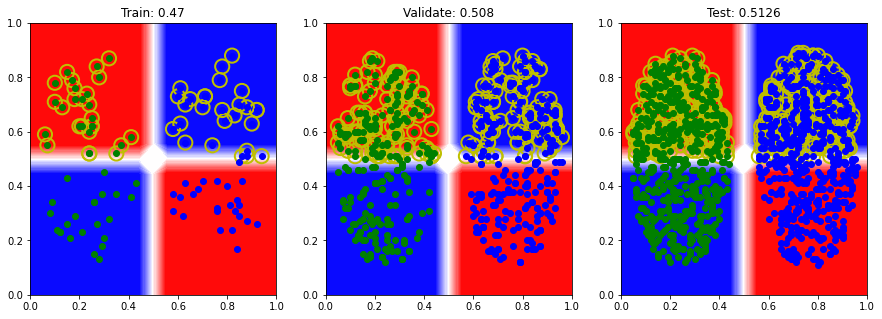

In [24]:
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

ax1, accuracy1 = make_accuracy_plot(train_X, train_y, model, ax1)
ax2, accuracy2 = make_accuracy_plot(validate_X, validate_y, model, ax2)
ax3, accuracy3 = make_accuracy_plot(test_X, test_y, model, ax3)

ax1.set_title('Train: {0}'.format(accuracy1))
ax2.set_title('Validate: {0}'.format(accuracy2))
ax3.set_title('Test: {0}'.format(accuracy3))